# Structured Output with LangChain + OpenAI

## Introduction
In this blog post, we will explore how to produce structured output using LangChain with OpenAI. LangChain is a powerful framework that simplifies the integration of language models into various applications, enabling us to manage inputs and outputs, including structured data formats, with ease. We will apply these capabilities to an Urban Heat Island Analysis project, leveraging NASA’s EarthData API to access MODIS Land Surface Temperature (LST) data. Our goal is to dynamically adjust parameters to ensure high-quality data for our analysis.

### Objectives

By the end of this lesson, you will be able to:

1. Set up the initial parameters for a data analysis project.
2. Visualize selected regions using Plotly Express.
3. Use LangChain and OpenAI to dynamically adjust project parameters.
4. Produce structured output using Pydantic models and LangChain.

## 1. Initial Setup

First, we need to manually set parameters for our analysis, such as the city region, coordinates for urban and rural areas, and the time range. This serves as our starting point and ensures we have a baseline for our project.

In [1]:
# Define the initial data parameters for the analysis
data_params = {
    'city_region_name': 'Houston, TX',  # Name of the city region
    'coordinates': {
        'urban': {'SW': [29.69193, -95.47998], 'NE': [29.90719, -95.2251]},  # Coordinates for the urban area
        'rural': {'SW': [30.5, -96.5], 'NE': [31.0, -96.0]}  # Coordinates for the rural area
    },
    'time': {
        'start': '2023-06-01T00:00:00Z',  # Start time for data collection
        'end': '2023-08-31T23:59:59Z'  # End time for data collection
    }
}
data_params

{'city_region_name': 'Houston, TX',
 'coordinates': {'urban': {'SW': [29.69193, -95.47998],
   'NE': [29.90719, -95.2251]},
  'rural': {'SW': [30.5, -96.5], 'NE': [31.0, -96.0]}},
 'time': {'start': '2023-06-01T00:00:00Z', 'end': '2023-08-31T23:59:59Z'}}

In this step, we specify the city region as Houston, TX, define the coordinates for both urban and rural areas, and set a time range for our analysis.


## 2. Visualizing Selected Regions:


Visualizing the selected regions helps us verify the accuracy of our coordinates. We use Plotly Express to generate sample points within the bounding boxes and plot them.

In [2]:
import pandas as pd
import plotly.express as px

def generate_sample_points(sw, ne, num_points=10):
    """Generate sample points within a given bounding box."""
    latitudes = [sw[0] + i * (ne[0] - sw[0]) / (num_points - 1) for i in range(num_points)]
    longitudes = [sw[1] + i * (ne[1] - sw[1]) / (num_points - 1) for i in range(num_points)]
    return [(lat, lon) for lat in latitudes for lon in longitudes]

# Generate sample points for urban and rural areas
sampled_coordinates = []
for region, bounding_box in data_params['coordinates'].items():
    
    sample_points = generate_sample_points(bounding_box['SW'], bounding_box['NE'])
    for lat, lon in sample_points:
        sampled_coordinates.append({'Region': region, 'Latitude': lat, 'Longitude': lon})

# Convert the sample points to a DataFrame
coords_df = pd.DataFrame(sampled_coordinates)
coords_df.head(2)

,Region,Latitude,Longitude
0,urban,29.69193,-95.47998
1,urban,29.69193,-95.45166


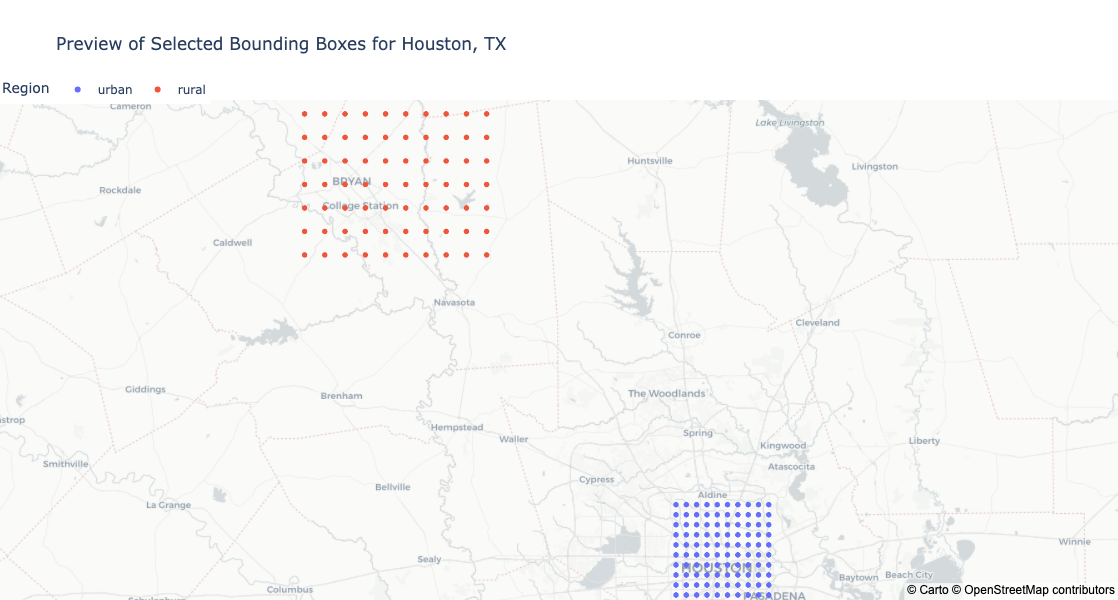

In [3]:
## Plot the region suggested
fig = px.scatter_mapbox(coords_df, lat="Latitude", lon="Longitude", color='Region',
                        # color_continuous_scale="Viridis", 
                        mapbox_style="carto-positron",
                        title=f"Preview of Selected Bounding Boxes for {data_params['city_region_name']}",
                        height=600, width=800)
## Update the layout
fig.update_layout(
    margin={"r":0, "l":0,'b':0, 't':100},# Remove left and right side margins
    legend={'orientation':"h", 'yanchor':"top", 'y':1.05, 'xanchor':"left", 'x':0}, # Move legend to top   
)
fig.show()

This visualization helps us confirm that the regions are correctly defined and prepares us for the next steps.


## 3. Getting New Suggested Parameters from OpenAI 

### Setting Up OpenAI + LangChain


Before using OpenAI’s API, we need to set up our environment. Follow these steps:



1. **Sign up for OpenAI's API:** 
   - Visit the [OpenAI website](https://www.openai.com) and sign up for an API key.



2. **Create a `.secret` folder in your home directory:**
   ```bash
   cd ~
   mkdir .secret
   ```

3. **Save your API key as a text file in the `.secret` folder:**
   - Open a text editor and paste your API key.
   - Save the file as `open-ai.txt` in the `.secret` folder. For example, you can use the following command in the terminal to create the file and save the API key:
   


4. **Export the key from the file to your `.bash_profile` or `.zshrc`:**
   - Open your `.bash_profile` for editing in VS Code:
   ```bash
   # If using bash
    code ~/.bash_profile

    # If using zsh, use: 
    code ~/.zshrc
    ```

- Add the following line to export the API key:
   ```bash
   export OPENAI_API_KEY=$(cat ~/.secret/open-ai.txt)
   ```
   
- Save the file and exit the editor 


After following these steps, your API key will be available in your environment variables as `OPENAI_API_KEY`.



**5.	Confirm the setup with Python to ensure the key is correctly loaded.**

You can confirm this with Python by importing the `os` module and checking the `os.environ` dictionary for 'OPENAI_API_KEY'.


In [4]:
import os
'OPENAI_API_KEY' in os.environ  # Should return True if the key is correctly loaded

True


> Note: Do NOT display the value of your OPENAI_API_KEY. If you accidentally expose your API credentials, OpenAI will automatically deactivate them, causing any program or app that uses it to break. 

### Using LangChain with ChatGPT

LangChain is a versatile framework designed to simplify the integration of language models into various applications, enabling seamless management of inputs and outputs, including structured data formats.

 By leveraging LangChain, developers can efficiently implement advanced AI functionalities, such as function calling, tool calling, and JSON mode, ensuring consistent and reliable outputs tailored to specific needs. This framework facilitates the creation of sophisticated AI-driven solutions across different domains, making it an essential tool for modern AI development. 

In [5]:
## Installing langchain
# !pip install -U langchain_openai langchain_core langchain_community pydantic

To consruct a chain using LangChain's newer LCEL (LangChain Execution Language) we need to define the following elements:
- The PromptTemplate
- The LLM model/Chat object.
- The OutputParser

#### LangChain's `PromptTemplate`

Prompt engineering/construction is vital for obtaining high-quality results from any Large Langauge Model (LLM). To get the best suggestions from the API, it is important to provide sufficient context in our prompt/query, while leaving the option to customize the prompt on-the-fly.

To do so, we will create a prompt_string that has our prompt plus a set of curly brackets around a `specs` variable, as-if it was an f-string ( but note that we are not actually using it as an f-string).

In [6]:

prompt_string = """I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
Help me select the urban and rural regions and time, keeping the following in mind:
{specs}
"""
print(prompt_string)

I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
Help me select the urban and rural regions and time, keeping the following in mind:
{specs}



We will use this prompt_string to construct a PromptTemplate object with LangChain, which will turn our f-string variable into a parameter that we pass in with our request. 

In [7]:
from langchain_core.prompts import PromptTemplate

# Converting the prompt_string to a PromptTemplate
prompt = PromptTemplate.from_template(prompt_string) 
prompt

PromptTemplate(input_variables=['specs'], template='I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. \nI need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.\nHelp me select the urban and rural regions and time, keeping the following in mind:\n{specs}\n')

In [8]:
# Any f-string variables in the prompt string become input_variables.
prompt.input_variables

['specs']

In [9]:
# The prompt string with the f-string variables replaced by the input values using the .format() method
specs_string= "1. Urban area should be within the city limits and rural area should be outside the city limits."
print(prompt.format(specs=specs_string))

I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
Help me select the urban and rural regions and time, keeping the following in mind:
1. Urban area should be within the city limits and rural area should be outside the city limits.



#### Instantiating an LLM

Next, we need to instantiate a language model. LangChain has separate packages for each of the LLMs it is compatible with. Since we are using OpenAI, we will use the ChatOpenAI object from `langchain_openai`. The ChatOpenAI object from LangChain will interact with the OpenAI API.

In [10]:
from langchain_openai import ChatOpenAI 
chat = ChatOpenAI(api_key=os.environ['OPENAI_API_KEY'], model="gpt-4o", temperature=0.0)
chat

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x1638b0950>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x164572710>, model_name='gpt-4o', temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='')

Setting the temperature to 0.0 ensures that the responses are deterministic and consistent.


#### Adding an Output Parser

The final piece of our chain is the output parser. While we could technically leave this out of our chain, it is better that we use the default StrOutputParser to convert our response into a simple string (instead of a JSON-like dictionary).

In [11]:
from langchain_core.output_parsers import StrOutputParser
output_parser = StrOutputParser()

### 4. Putting it All Together: Our First Chain

We construct the final chain using the prompt, LLM, and output parser. This chain allows us to query OpenAI for new parameters.


Our chain starts with the prompt, followed by a pipe symbol `|` and then the LLM object, followed by another pipe, and finally the output parser. 

In [12]:
# Constructing Our Chain
chain = prompt | chat | output_parser
chain

PromptTemplate(input_variables=['specs'], template='I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. \nI need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.\nHelp me select the urban and rural regions and time, keeping the following in mind:\n{specs}\n')
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x1638b0950>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x164572710>, model_name='gpt-4o', temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='')
| StrOutputParser()

To use the chain we use the .invoke method and must provide the `input_variables` that are required by the prompt template.

In [13]:
# Using the input variables to provide the necessary information
specs_string = """1. Urban area should be within the city limits and rural area should be outside the city limits.
2. The urban area should be selected within the southern US region to study the urban heat island effect. 
"""

# Invoke the chain to get the response
response = chain.invoke({'specs':specs_string})
print(response)

For your urban heat island analysis project using MODIS data, you can consider selecting an urban area and a nearby rural area in the southern United States. Here are some steps and suggestions to help you select appropriate regions and time ranges:

### Step 1: Select the Urban Area
Choose a city in the southern US that is known for its significant urban heat island effect. Some suitable cities include:

- **Houston, Texas**
- **Atlanta, Georgia**
- **Miami, Florida**
- **New Orleans, Louisiana**

For this example, let's choose **Houston, Texas**.

### Step 2: Define the Urban Area
Identify the city limits of Houston. You can use GIS tools or online maps to get the exact boundaries. For simplicity, you can use a central part of the city that is densely built-up.

### Step 3: Select the Rural Area
Choose a rural area outside the city limits of Houston. Ensure that this area is non-overlapping with the urban area and is representative of a rural environment. A good choice would be an ar

In [14]:
# ChatGPT responds with Markdown-stytled text, so we can use IPython's `Markdown` class to render it
from IPython.display import Markdown, display
# display(Markdown(response))

To leverage the new suggestions from ChatGPT, we would have to manually construct a new `data_params` dict using the raw text from the response. This is a manual process that can be automated by using a more complex Output Parser: the Json.

### 5. Getting Structured Output from LangChain

#### Structured Output

We aim to produce a JSON-dictionary with the same structure as our original data_params. To achieve this, we define a Pydantic data model.

In [15]:
## Defining the structured output desired from chat gpt
from pydantic import BaseModel, Field
from typing import List, Optional, Text, Dict
from langchain_core.output_parsers import JsonOutputParser

# Define Pydantic models for structured output
class Coordinates(BaseModel):
    SW: List[float]
    NE: List[float]

class RegionCoordinates(BaseModel):
    rural: Optional[Coordinates]
    urban: Optional[Coordinates]

class DataParams(BaseModel):
    city_region_name: str
    coordinates: Optional[RegionCoordinates]
    time: Dict[str, str]



We will insert a new input_variable in our PromptTempalte for the format_instructions, which will be filled in as a partial prompt using `prompt.partial().`

In [16]:
from langchain_core.prompts import PromptTemplate

# Define the prompt template for the language model
prompt_string = """
I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas.
I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
Help me select the urban and rural regions and time, keeping the following in mind:
{specs}

Format Instructions:
{format_instructions}
"""
prompt = PromptTemplate.from_template(prompt_string)

# Define the output parser with the Pydantic model
output_parser = JsonOutputParser(pydantic_object=DataParams)

# Update the prompt template to include format instructions for JSON output
prompt = prompt.partial(format_instructions=output_parser.get_format_instructions())

# Construct the chain using the prompt, language model, and output parser
chain = prompt | chat | output_parser

# Define the specifications for the query

specs = """Select a region that will be a perfect example of the effects of urban heat islands.
Select identically-sized nearby non-overlapping regions from the selected area to minimize the size of the dataset.
Do not select a city in the desert or near a large body of water."""

# Invoke the chain to get the response in structured format
data_params = chain.invoke({'specs': specs})
data_params # Print the structured response from the language model

{'city_region_name': 'Atlanta, Georgia',
 'coordinates': {'urban': {'SW': [33.640411, -84.551618],
   'NE': [33.849181, -84.289389]},
  'rural': {'SW': [33.349181, -84.551618], 'NE': [33.558951, -84.289389]}},
 'time': {'start': '2022-06-01', 'end': '2022-08-31'}}

This structured output can be directly used to adjust our parameters for the Urban Heat Island Analysis project.


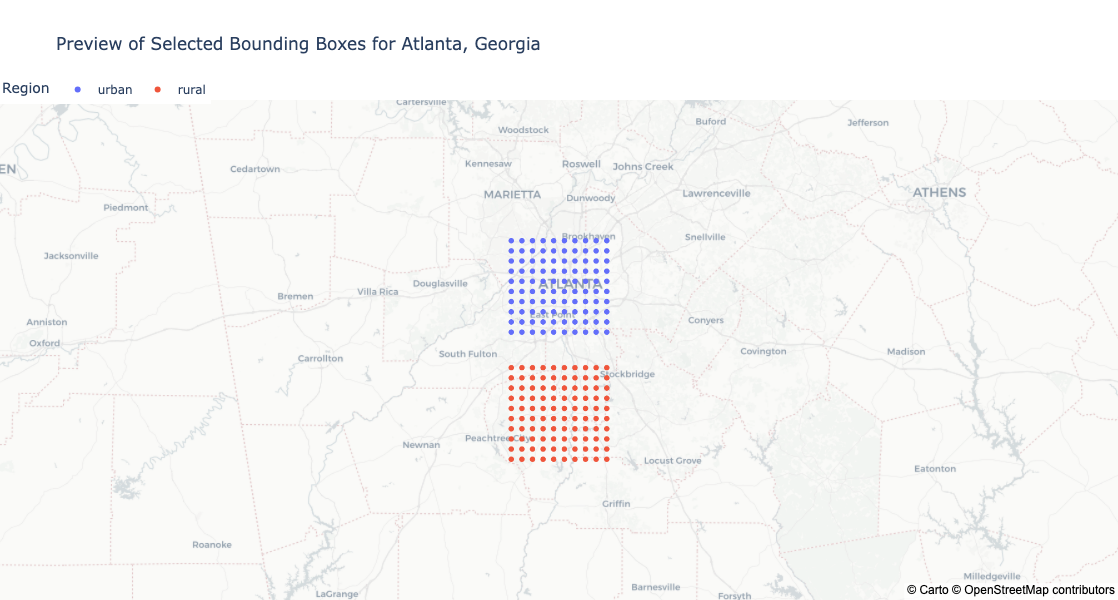

In [17]:
# Generate sample points for urban and rural areas
sampled_coordinates = []
for region, bounding_box in data_params['coordinates'].items():
    sample_points = generate_sample_points(bounding_box['SW'], bounding_box['NE'])
    for lat, lon in sample_points:
        sampled_coordinates.append({'Region': region, 'Latitude': lat, 'Longitude': lon})

# Convert the sample points to a DataFrame
coords_df = pd.DataFrame(sampled_coordinates)

## Plot the region suggested
fig = px.scatter_mapbox(coords_df, lat="Latitude", lon="Longitude", color='Region',
                        # color_continuous_scale="Viridis", 
                        mapbox_style="carto-positron",
                        title=f"Preview of Selected Bounding Boxes for {data_params['city_region_name']}",
                        height=600, width=800)
## Update the layout
fig.update_layout(
    margin={"r":0, "l":0,'b':0, 't':100},# Remove left and right side margins
    legend={'orientation':"h", 'yanchor':"top", 'y':1.05, 'xanchor':"left", 'x':0}, # Move legend to top   
)
fig.show()

## Conclusion

Using LangChain with OpenAI allows us to dynamically adjust parameters and obtain structured outputs, significantly improving our data analysis workflow. This setup can be adapted for various projects requiring precise and structured data retrieval. By automating the parameter selection process, we can ensure high-quality data and streamline our analysis.

Feel free to reach out with questions or feedback, and stay tuned for more advanced tutorials!


___

# APPENDIX

In [ ]:
raise Exception("Stop here")

### Created a function that asks ChatGPT for suggested parameters

In [18]:
def suggest_data_params(specs: str, temperature=0.0, model_type='gpt-4o', return_json=True) -> str:
    """
    Suggests data parameters for downloading MODIS data for a specific region and time range.
    
    Args:
        query (str): The query describing the requirements for the data download.
        temperature (float, optional): The temperature parameter for the language model. Defaults to 0.1.
        model_type (str, optional): The type of language model to use. Defaults to 'gpt-4o'.
        return_llm (bool, optional): Whether to return the language model chain. Defaults to False.
        return_json (bool, optional): Whether to return the response as JSON. Defaults to True.
    
    Returns:
        str: The response from the language model chain or the JSON response, depending on the value of return_json.
    """
    
    # The prompt template for suggesting data parameters
    prompt = """
    I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
    I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
    Help me select the urban and rural regions and time following the instructions below.
    {specs}
    
    Provide me the data parameters for the download (city_region_name, coordinates as SW [lat,long] NE [lat,long], time_start named 'start', time_end named 'end') in the following format:
    Format Instructions:
    Use the 2-letter abbreviations for the state.
    {format_instructions}
    """
    # Create a ChatPromptTemplate object
    final_prompt_template = PromptTemplate.from_template(prompt)

    # Get api key for OpenAI from the environment or session state (if on Streamlit)
    api_key = os.getenv('OPENAI_API_KEY')
        
    # Instantiate the language model and setting the specific model (chat-gpto is newest and reasonable price)
    # and  set the temperature (creativity level)
    llm = ChatOpenAI(temperature=temperature, model=model_type, api_key=api_key)
    
    if return_json:
        # # JsonOutputParser will use the data model classes from above
        parser = JsonOutputParser(pydantic_object=DataParams,)    
        # Add formatting instructions for pydantic
        instructions =  parser.get_format_instructions()
            
    else:
        ## StrOutputParser will return the response as a string
        parser = StrOutputParser(output_key="response")
        # Manually defining the format instructions
        instructions = "Respond with text for each topic as a nested list with the topic number,  descriptive label,top words, and short insight."
        
        
    ## Adding the instructions to the prompt template
    final_prompt_template = final_prompt_template.partial(format_instructions=instructions)
    
    
    # Making the final chain
    llm_chain = final_prompt_template | llm | parser
    
    # Invoke the chain with the query to get the response
    return llm_chain.invoke(input=dict(specs=specs))

In [19]:

specs = """Select a region that will be a perfect example of the effects of urban heat islands.
Select small identically-sized nearby non-overlapping regions from the selected area to minimize the size of the dataset.
Do not use Texas."""

# ask ChatGPT to suggest another set of parameters
chatgpt_params = suggest_data_params(specs=specs, 
                                    return_json=True, temperature=0.0)
chatgpt_params

{'city_region_name': 'Phoenix, AZ',
 'coordinates': {'urban': {'SW': [33.4484, -112.074],
   'NE': [33.4584, -112.064]},
  'rural': {'SW': [33.3484, -112.174], 'NE': [33.3584, -112.164]}},
 'time': {'start': '2022-01-01', 'end': '2022-12-31'}}

In [20]:
preview_regions(chatgpt_params)

NameError: name 'preview_regions' is not defined

In [ ]:

specs = """Select a region that will be a perfect example of the effects of urban heat islands.
Select small identically-sized nearby non-overlapping regions from the selected area to minimize the size of the dataset.
Select a region in a non-desert area."""

# ask ChatGPT to suggest another set of parameters
chatgpt_params = suggest_data_params(specs=specs, 
                                    return_json=True, temperature=0.0)
pprint(chatgpt_params)
preview_regions(chatgpt_params)

And then we can use these new data_params to download the NASA Earth Science data, which will be covered in a later blog post. 


In [ ]:
# os.makedirs("blog", exist_ok=True)

In [ ]:
# !pip freeze

In [ ]:
# !pip freeze >> blog/requirements.txt

In [ ]:
# with open("blog/requirements.txt", "r") as f:
#     print(f.read()) 

`ADD SEGWAY NOW THAT DOWNLOAD CODE NOT INCLUDED`
The processing code for working with the downloaded files is beyond the scope of this blog post. However, suffice it to say that there may be data quality issues or other challenges that need to be addressed. 

For example, the downloaded files may contain a large amount of missing or corrupted data. These issues can be addressed using a combination of data preprocessing techniques, data cleaning methods, and data transformation tools. However, if we can adjust our starting parameters dynamically, we can find parameters with fewer issues, allowing a cleaner analysis.

To do so, we will leverage the OpenAI API with LangChain to query ChatGPT for new suggested parameters from within our notebook.

In [ ]:
raise Exception("Stop here") 

In [ ]:
def preview_regions(data_params):
    

    # Dataframe to store results
    sampled_coordinates = []

    # Check if any coordinates within the bounding boxes are over sea
    for region, bounding_box in data_params['coordinates'].items():
        # Generate sample points within the bounding box
        sample_points = generate_sample_points(bounding_box['SW'], bounding_box['NE'], num_points=10)
        for lat, lon in sample_points:
            sampled_coordinates.append({'Region': region, 'Latitude': lat, 'Longitude': lon})

    # Convert results to DataFrame
    coords_df = pd.DataFrame(sampled_coordinates)
    
    
        ## Plot the region suggested
    fig = px.scatter_mapbox(coords_df, lat="Latitude", lon="Longitude", color='Region',
                            # color_continuous_scale="Viridis", 
                            mapbox_style="carto-positron",
                            title=f"Preview of Selected Bounding Boxes for {data_params['city_region_name']}",
                            height=600, width=600)

    # Remove left and right side margins
    fig.update_layout(
        margin={"r":0, "l":0,'b':0, 't':100},
        legend={'orientation':"h", 'yanchor':"top", 'y':1.05, 'xanchor':"left", 'x':0},
        
    )

    return fig
    ## Save fig for README
    # fig.write_image(f"{img_dir}selected_regions.png")

We aim to produce a JSON-dictionary with the same structure as our original data_params. To achieve this, we define a Pydantic data model.

### Structured Output

- We can construct a Pydantic data model to control structured output of API parameters from ChatGPT.

The pydantic data model will be a class that contains defined the exact structure of the desired output, including data types.

The default example from the langchain documentation is as follows:

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

# Create the prompt    
prompt_template_string = """Tell me a joke about {topic}
Format Instructions:
{format_instructions}
"""
prompt = PromptTemplate.from_template(prompt_template_string)

# Create the LLM
chat = ChatOpenAI(api_key=os.environ['OPENAI_API_KEY'], model="gpt-4o", temperature=0.0)


# Specify the structured output for the LLM
class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")
    
# Create the output parser with the structured output
output_parser = JsonOutputParser(pydantic_object=Joke)

# Add the format instructions from the Output Parser using the .partial PromptTemplate method
prompt = prompt.partial(format_instructions=output_parser.get_format_instructions())

# Construct the chain
chain = prompt | chat | output_parser
chain

In [ ]:
response = chain.invoke({'topic':'chickens'})
response.keys()

In [ ]:
print(response['setup'])
print(response['punchline'])

In [ ]:
# preview_regions(data_params)

### Unused Sentence

Instead of using f-strings to construct the final prompt for the language model, we can use `langchain` library to create an LLM chain that automatically formats the prompt with the query provided by the user. We do so by converting our string prompt to a PromptTemplate object using the .from_template method. 


### [`STILL NEEDED?`]Reproducible and Customizable Queries/Prompts 

We got a lot of great information from our prompt:
- We have new coordinates includes in our result,
- We have new time period

but there are 2 issues to resolve:
- Continuing to tweak and iterate on our prompt to get updated results 
- we received a large amount of unnecessary text, if all we want is the new values for our data_params dictionary. 


Therefore, we will construct a detailed system prompt that includes a `query` parameter, which is where we will add additional details to our requests. 
